# Running Spatial Covariance model on cell2location-derived cell type densities of invading trophoblast

### (FullRandomEffectsModel)

## On all invading trophoblast within the new updated donor P13 atlas (SN+multiome)

### no chip-specific cell state choice, this can be incorporated later

Using cell2location-derived cell type densities of new full donor P13 SN+multiome states in all relevant Visium chips (of donors P13, P14 and Hrv43, 8 chips overall)

PER CHIP analysis, model is fitted per cell type pair at a time

22.02.2022: using final cell2location results (dated 23.11.2021) and corresponding tissue regions identification using SpatialDE2 tissue segmentation (also dated 23.11.2021, analysis is done in notebook S1 in 2-1_stOrder_inv_troph directory) + after a bug fix (mistake in calculating the `quad` quadratic part of the likelihood of multivariate Gaussian distribution)

In [1]:
import sys, os
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
sys.path.insert(1, '/nfs/team292/aa22/SpatialDE_pairwise_correlation/')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scanpy as sc
import anndata
import NaiveDE # needs `pip install NaiveDE`
from scipy.sparse import issparse
from glimix_core.lmm import Kron2Sum # needs `pip install glimix-core`
import tqdm

In [3]:
%%bash
pip freeze

absl-py==0.13.0
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1618520051705/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1624539389047/work/dist
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
astunparse==1.6.3
async-generator==1.10
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1620387926260/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1619719576210/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1618230623929/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1612213472466/work
brent-search==2.0.1
brotlipy==0.7.0
cached-property @ file:///home/conda/feedstock_root/build_artifacts/cached_property_1615209429212/work
cachetools==4.2.2
certifi==2021.5.30
cffi @ file:///home/conda/f

bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


# Reading in Visium data for donors P13, P14 and Hrv43

In [4]:
# reading adatas 
# trying all at once
IDs = ['34914_WS_PLA_S9101764', # P13 main 4 chips
           '34914_WS_PLA_S9101765',
           '34914_WS_PLA_S9101766',
           '34914_WS_PLA_S9101767',
           '34882_WS_PLA_S9101769', # P14 2 chips
           '34882_WS_PLA_S9101770',
           
           # from batch 2
           '36173_Pla_HDBR9518710', # Hrv43
           '36173_Pla_Camb9518737', # P13 extra chip
           
          ]

adatas_visium = {}

for ID in IDs:
    print(ID)
    
    if ID in ['34914_WS_PLA_S9101764', # P13 main 4 chips
           '34914_WS_PLA_S9101765',
           '34914_WS_PLA_S9101766',
           '34914_WS_PLA_S9101767',
           '34882_WS_PLA_S9101769', # P14 2 chips
           '34882_WS_PLA_S9101770',]:
        path = '/lustre/scratch117/cellgen/team292/aa22/data/202008_MFI_Visium/20200901_new_data_spaceranger110/spaceranger110_count_' + ID + '_GRCh38-3_0_0-premrna/'
    if ID in ['36173_Pla_HDBR9518710', # Hrv43
           '36173_Pla_Camb9518737', # P13 extra chip
             ]:
        path = '/lustre/scratch117/cellgen/team292/aa22/data/202103_MFI_Visium_batch_2/spaceranger110_count_' + ID + '_GRCh38-3_0_0_premrna/'
           
    
    adatas_visium[ID] = sc.read_visium(path)
    adatas_visium[ID].obs['sample'] = ID
    adatas_visium[ID].obs['barcode_sample'] = [idx + '_' + ID for idx in adatas_visium[ID].obs_names]
    adatas_visium[ID].obs.set_index('barcode_sample', inplace=True)
    adatas_visium[ID].var_names_make_unique()
    

34914_WS_PLA_S9101764


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


34914_WS_PLA_S9101765


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


34914_WS_PLA_S9101766


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


34914_WS_PLA_S9101767


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


34882_WS_PLA_S9101769


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


34882_WS_PLA_S9101770


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


36173_Pla_HDBR9518710


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


36173_Pla_Camb9518737


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
# adding QC metrics to the visium objects
for ID in IDs:
    adatas_visium[ID].obs['n_counts'] = adatas_visium[ID].X.sum(1)
    adatas_visium[ID].obs['log_counts'] = np.log(adatas_visium[ID].obs['n_counts'])
    adatas_visium[ID].obs['n_genes'] = (adatas_visium[ID].X > 0).sum(1)
    
    mito_genes = [name for name in adatas_visium[ID].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    adatas_visium[ID].obs['percent_mito'] = np.sum(
        adatas_visium[ID][:, mito_genes].X, axis=1).A1 / np.sum(adatas_visium[ID].X, axis=1).A1
    # saving raw counts in .raw for now
    adatas_visium[ID].raw = adatas_visium[ID].copy()

# Reading in cell2location ouput

### Discrete cell states, with pre-mRNA-aligned Visium

In [9]:
# 24.11.2021: FINALLY the best cell2loc results so far (dated 23.11.2021) 
# using SN + multiome P13: trophoblast states from P13-only analysis and 
# other states - from all-donors analysis (subsetted to P13)
# hence this run is further referred to as 'hybrid'
path_hybrid = '/lustre/scratch117/cellgen/team292/aa22/cell2loc_files/in_vivo_onto_in_vivo_mapping/results/20211123_P13_new_full_atlas_SN_and_multiome_updated_onto_all_relevant_Visium_chips_with_LF_gene_filter/cell2location_map/'

# object with all used Visium chips concatenated (in this case all 8 relevant Visium chips)
sp_mapping_hybrid = sc.read(path_hybrid + 'sp.h5ad')



In [10]:
for ID in IDs:
    print(ID)
    #print(col)
    for col in sp_mapping_hybrid.obsm['q05_cell_abundance_w_sf']:
        col_chopped = col[18:] + '_hybrid'
        #print(col_chopped)
        adatas_visium[ID].obs[col_chopped] = sp_mapping_hybrid.obsm['q05_cell_abundance_w_sf'].loc[adatas_visium[ID].obs_names, col]
        
        

34914_WS_PLA_S9101764
34914_WS_PLA_S9101765
34914_WS_PLA_S9101766
34914_WS_PLA_S9101767
34882_WS_PLA_S9101769
34882_WS_PLA_S9101770
36173_Pla_HDBR9518710
36173_Pla_Camb9518737


In [11]:
c2l_tags_hybrid = [elem for elem in adatas_visium['34914_WS_PLA_S9101764'].obs.columns if '_hybrid' in elem]
c2l_tags_hybrid[:5]

['w_sf_B_cells_hybrid',
 'w_sf_DC_hybrid',
 'w_sf_EVT_1_hybrid',
 'w_sf_EVT_2_hybrid',
 'w_sf_Endo_F_hybrid']

In [12]:
# reading in region assignment of spots
# this is done to then only use regions 'decidua_and_villi_tips' and 'myometrium'
# in analysis of spatial colocation of invading trophoblast states
regions = {}

for ID in IDs:
    print(ID)
    regions[ID] = pd.read_csv('./Visium_regions_of_spots/20211123_spot_assignment_to_regions_SpatialDE2_tissue_segmentation_chip_' + ID + '.csv', 
                              index_col=0)    
    #regions[ID].index = [idx + '_WS_' + ID for idx in regions[ID].index]
    adatas_visium[ID].obs['region'] = regions[ID].loc[adatas_visium[ID].obs_names,'region']
    print('regions in this Visium chip:', np.unique(adatas_visium[ID].obs['region'], return_counts=True), '\n')

34914_WS_PLA_S9101764
regions in this Visium chip: (array(['decidua_and_villi_tips', 'myometrium'], dtype=object), array([1083, 2485])) 

34914_WS_PLA_S9101765
regions in this Visium chip: (array(['decidua_and_villi_tips', 'myometrium', 'placenta'], dtype=object), array([1677,  680, 1498])) 

34914_WS_PLA_S9101766
regions in this Visium chip: (array(['decidua_and_villi_tips', 'myometrium', 'placenta'], dtype=object), array([1175,   76, 2628])) 

34914_WS_PLA_S9101767
regions in this Visium chip: (array(['decidua_and_villi_tips', 'myometrium', 'placenta'], dtype=object), array([1924, 1178, 1084])) 

34882_WS_PLA_S9101769
regions in this Visium chip: (array(['decidua_and_villi_tips', 'lowQ_or_not_under_tissue', 'myometrium'],
      dtype=object), array([ 669,  547, 1914])) 

34882_WS_PLA_S9101770
regions in this Visium chip: (array(['decidua_and_villi_tips', 'lowQ_or_not_under_tissue', 'myometrium'],
      dtype=object), array([ 624,  153, 2578])) 

36173_Pla_HDBR9518710
regions in this 

In [13]:
# discarding the 'lowQC_or_not_under_tissue' spots
for ID in IDs:
    print(ID)
    print('shape of adata_visium:', adatas_visium[ID].X.shape)
    adatas_visium[ID] = adatas_visium[ID][adatas_visium[ID].obs['region'].isin(['decidua_and_villi_tips',
                                                                                'placenta','myometrium'])].copy()
    print('shape of adata_visium after discarding lowQC_or_not_under_tissue spots:', adatas_visium[ID].X.shape)


34914_WS_PLA_S9101764
shape of adata_visium: (3568, 33538)
shape of adata_visium after discarding lowQC_or_not_under_tissue spots: (3568, 33538)
34914_WS_PLA_S9101765
shape of adata_visium: (3855, 33538)
shape of adata_visium after discarding lowQC_or_not_under_tissue spots: (3855, 33538)
34914_WS_PLA_S9101766
shape of adata_visium: (3879, 33538)
shape of adata_visium after discarding lowQC_or_not_under_tissue spots: (3879, 33538)
34914_WS_PLA_S9101767
shape of adata_visium: (4186, 33538)
shape of adata_visium after discarding lowQC_or_not_under_tissue spots: (4186, 33538)
34882_WS_PLA_S9101769
shape of adata_visium: (3130, 33538)
shape of adata_visium after discarding lowQC_or_not_under_tissue spots: (2583, 33538)
34882_WS_PLA_S9101770
shape of adata_visium: (3355, 33538)
shape of adata_visium after discarding lowQC_or_not_under_tissue spots: (3202, 33538)
36173_Pla_HDBR9518710
shape of adata_visium: (1216, 33538)
shape of adata_visium after discarding lowQC_or_not_under_tissue spots:

In [14]:
adatas_visium['34914_WS_PLA_S9101764'].obs

,in_tissue,array_row,array_col,sample,n_counts,log_counts,n_genes,percent_mito,w_sf_B_cells_hybrid,w_sf_DC_hybrid,...,w_sf_dS2_hybrid,w_sf_dS3_hybrid,w_sf_dT_cells_hybrid,w_sf_dT_regs_hybrid,w_sf_eEVT_hybrid,w_sf_fF1_hybrid,w_sf_fF2_hybrid,w_sf_iEVT_hybrid,w_sf_uSMC_hybrid,region
barcode_sample,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1_34914_WS_PLA_S9101764,1,50,102,34914_WS_PLA_S9101764,12444.0,9.428994,3877,0.014224,0.060838,0.146822,...,0.131673,0.211407,0.075955,0.089355,0.154827,0.154210,0.067015,3.772072,10.303452,myometrium
AAACAATCTACTAGCA-1_34914_WS_PLA_S9101764,1,3,43,34914_WS_PLA_S9101764,12286.0,9.416216,3811,0.014407,0.071699,0.368816,...,0.025892,0.250685,0.125899,0.160814,0.006453,0.457115,0.274455,0.010157,14.068544,myometrium
AAACACCAATAACTGC-1_34914_WS_PLA_S9101764,1,59,19,34914_WS_PLA_S9101764,5291.0,8.573763,2211,0.031563,0.015815,0.082095,...,0.005608,0.046577,0.026094,0.037021,0.000772,0.124578,0.031312,0.000769,11.321204,myometrium
AAACAGAGCGACTCCT-1_34914_WS_PLA_S9101764,1,14,94,34914_WS_PLA_S9101764,8615.0,9.061260,3272,0.024492,0.033652,0.050152,...,0.184628,1.776880,0.050005,0.044988,0.065874,0.042044,0.019016,2.247340,1.461058,decidua_and_villi_tips
AAACAGCTTTCAGAAG-1_34914_WS_PLA_S9101764,1,43,9,34914_WS_PLA_S9101764,11053.0,9.310457,3668,0.011309,0.097381,0.389111,...,0.029206,0.557351,0.106435,0.224961,0.002202,0.411167,0.138087,0.001726,11.918576,myometrium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1_34914_WS_PLA_S9101764,1,31,77,34914_WS_PLA_S9101764,7523.0,8.925720,2785,0.031370,0.027461,0.148672,...,0.011085,0.054968,0.047101,0.079095,0.016119,0.175627,0.053941,0.267239,13.002522,myometrium
TTGTTTCACATCCAGG-1_34914_WS_PLA_S9101764,1,58,42,34914_WS_PLA_S9101764,7442.0,8.914895,2737,0.018812,0.022510,0.155582,...,0.009694,0.097812,0.049280,0.088114,0.000491,0.187701,0.050349,0.000514,14.161224,myometrium
TTGTTTCATTAGTCTA-1_34914_WS_PLA_S9101764,1,60,30,34914_WS_PLA_S9101764,5065.0,8.530109,2286,0.022310,0.018422,0.073783,...,0.004493,0.039729,0.029287,0.038688,0.000208,0.130446,0.088848,0.000104,16.027699,myometrium


In [15]:
adatas_visium.keys()

dict_keys(['34914_WS_PLA_S9101764', '34914_WS_PLA_S9101765', '34914_WS_PLA_S9101766', '34914_WS_PLA_S9101767', '34882_WS_PLA_S9101769', '34882_WS_PLA_S9101770', '36173_Pla_HDBR9518710', '36173_Pla_Camb9518737'])

In [16]:
# concatenate all adata objects
adatas_visium_concat = adatas_visium['34914_WS_PLA_S9101764'].concatenate(list(adatas_visium.values())[1:], join='outer')

In [17]:
adatas_visium_concat.obs

,in_tissue,array_row,array_col,sample,n_counts,log_counts,n_genes,percent_mito,w_sf_B_cells_hybrid,w_sf_DC_hybrid,...,w_sf_dS3_hybrid,w_sf_dT_cells_hybrid,w_sf_dT_regs_hybrid,w_sf_eEVT_hybrid,w_sf_fF1_hybrid,w_sf_fF2_hybrid,w_sf_iEVT_hybrid,w_sf_uSMC_hybrid,region,batch
barcode_sample,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1_34914_WS_PLA_S9101764-0,1,50,102,34914_WS_PLA_S9101764,12444.0,9.428994,3877,0.014224,0.060838,0.146822,...,0.211407,0.075955,0.089355,0.154827,0.154210,0.067015,3.772072,10.303452,myometrium,0
AAACAATCTACTAGCA-1_34914_WS_PLA_S9101764-0,1,3,43,34914_WS_PLA_S9101764,12286.0,9.416216,3811,0.014407,0.071699,0.368816,...,0.250685,0.125899,0.160814,0.006453,0.457115,0.274455,0.010157,14.068544,myometrium,0
AAACACCAATAACTGC-1_34914_WS_PLA_S9101764-0,1,59,19,34914_WS_PLA_S9101764,5291.0,8.573763,2211,0.031563,0.015815,0.082095,...,0.046577,0.026094,0.037021,0.000772,0.124578,0.031312,0.000769,11.321204,myometrium,0
AAACAGAGCGACTCCT-1_34914_WS_PLA_S9101764-0,1,14,94,34914_WS_PLA_S9101764,8615.0,9.061260,3272,0.024492,0.033652,0.050152,...,1.776880,0.050005,0.044988,0.065874,0.042044,0.019016,2.247340,1.461058,decidua_and_villi_tips,0
AAACAGCTTTCAGAAG-1_34914_WS_PLA_S9101764-0,1,43,9,34914_WS_PLA_S9101764,11053.0,9.310457,3668,0.011309,0.097381,0.389111,...,0.557351,0.106435,0.224961,0.002202,0.411167,0.138087,0.001726,11.918576,myometrium,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1_36173_Pla_Camb9518737-7,1,31,77,36173_Pla_Camb9518737,5667.0,8.642415,2491,0.007411,0.019438,0.028318,...,0.583205,0.027985,0.019144,0.204748,0.016574,0.012625,2.994178,0.063708,decidua_and_villi_tips,7
TTGTTTCACATCCAGG-1_36173_Pla_Camb9518737-7,1,58,42,36173_Pla_Camb9518737,1262.0,7.140453,834,0.036450,0.001759,0.004271,...,0.796988,0.002386,0.000934,0.008839,0.008699,0.006368,0.001758,0.002350,decidua_and_villi_tips,7
TTGTTTCATTAGTCTA-1_36173_Pla_Camb9518737-7,1,60,30,36173_Pla_Camb9518737,403.0,5.998937,314,0.044665,0.000322,0.001080,...,0.095372,0.000757,0.000285,0.008536,0.001380,0.001197,0.009167,0.001142,placenta,7


In [18]:
np.unique(adatas_visium_concat.obs['region'], return_counts=True)

(array(['decidua_and_villi_tips', 'myometrium', 'placenta'], dtype=object),
 array([10041,  9367,  7152]))

In [19]:
# we are ignoring placenta region for the trajectory analysis
adatas_visium_concat = adatas_visium_concat[adatas_visium_concat.obs['region'].isin(['decidua_and_villi_tips',
                                                                                     'myometrium'])].copy()


In [20]:
adatas_visium_concat.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'sample', 'n_counts',
       'log_counts', 'n_genes', 'percent_mito', 'w_sf_B_cells_hybrid',
       'w_sf_DC_hybrid', 'w_sf_EVT_1_hybrid', 'w_sf_EVT_2_hybrid',
       'w_sf_Endo_F_hybrid', 'w_sf_Endo_L_hybrid', 'w_sf_Endo_M_hybrid',
       'w_sf_GC_hybrid', 'w_sf_Granulocytes_hybrid', 'w_sf_HOFB_hybrid',
       'w_sf_ILC3_hybrid', 'w_sf_M3_hybrid', 'w_sf_MO_hybrid',
       'w_sf_NK_hybrid', 'w_sf_PV_hybrid', 'w_sf_Plasma_hybrid',
       'w_sf_SCT_hybrid', 'w_sf_T_cells_hybrid', 'w_sf_VCT_hybrid',
       'w_sf_VCT_CCC_hybrid', 'w_sf_VCT_fusing_hybrid', 'w_sf_VCT_p_hybrid',
       'w_sf_dDC_hybrid', 'w_sf_dEpi_lumenal_hybrid',
       'w_sf_dEpi_secretory_hybrid', 'w_sf_dM1_hybrid', 'w_sf_dM2_hybrid',
       'w_sf_dNK1_hybrid', 'w_sf_dNK2_hybrid', 'w_sf_dNK3_hybrid',
       'w_sf_dS1_hybrid', 'w_sf_dS2_hybrid', 'w_sf_dS3_hybrid',
       'w_sf_dT_cells_hybrid', 'w_sf_dT_regs_hybrid', 'w_sf_eEVT_hybrid',
       'w_sf_fF1_hybrid', 'w_sf_fF2_hybri

In [21]:
# getting rid of some irrelevant columns
ct_data_cols = list(set(adatas_visium_concat.obs.columns) - set(['in_tissue', 'array_row', 'array_col', 'sample', 'n_counts',
       'log_counts', 'n_genes', 'percent_mito','region', 'batch']))

In [22]:
# subsetting to only invading trophoblast
ct_data_cols = ['w_sf_VCT_CCC_hybrid', 'w_sf_EVT_1_hybrid', 'w_sf_EVT_2_hybrid', 
                'w_sf_eEVT_hybrid', 'w_sf_iEVT_hybrid', 'w_sf_GC_hybrid']

In [23]:
adatas_visium_concat

AnnData object with n_obs × n_vars = 19408 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'w_sf_B_cells_hybrid', 'w_sf_DC_hybrid', 'w_sf_EVT_1_hybrid', 'w_sf_EVT_2_hybrid', 'w_sf_Endo_F_hybrid', 'w_sf_Endo_L_hybrid', 'w_sf_Endo_M_hybrid', 'w_sf_GC_hybrid', 'w_sf_Granulocytes_hybrid', 'w_sf_HOFB_hybrid', 'w_sf_ILC3_hybrid', 'w_sf_M3_hybrid', 'w_sf_MO_hybrid', 'w_sf_NK_hybrid', 'w_sf_PV_hybrid', 'w_sf_Plasma_hybrid', 'w_sf_SCT_hybrid', 'w_sf_T_cells_hybrid', 'w_sf_VCT_hybrid', 'w_sf_VCT_CCC_hybrid', 'w_sf_VCT_fusing_hybrid', 'w_sf_VCT_p_hybrid', 'w_sf_dDC_hybrid', 'w_sf_dEpi_lumenal_hybrid', 'w_sf_dEpi_secretory_hybrid', 'w_sf_dM1_hybrid', 'w_sf_dM2_hybrid', 'w_sf_dNK1_hybrid', 'w_sf_dNK2_hybrid', 'w_sf_dNK3_hybrid', 'w_sf_dS1_hybrid', 'w_sf_dS2_hybrid', 'w_sf_dS3_hybrid', 'w_sf_dT_cells_hybrid', 'w_sf_dT_regs_hybrid', 'w_sf_eEVT_hybrid', 'w_sf_fF1_hybrid', 'w_sf_fF2_hybrid', 'w_sf_iEVT_hybrid', 'w_sf_uSMC_hybrid', '

In [24]:
adatas_visium_concat.obs

,in_tissue,array_row,array_col,sample,n_counts,log_counts,n_genes,percent_mito,w_sf_B_cells_hybrid,w_sf_DC_hybrid,...,w_sf_dS3_hybrid,w_sf_dT_cells_hybrid,w_sf_dT_regs_hybrid,w_sf_eEVT_hybrid,w_sf_fF1_hybrid,w_sf_fF2_hybrid,w_sf_iEVT_hybrid,w_sf_uSMC_hybrid,region,batch
barcode_sample,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1_34914_WS_PLA_S9101764-0,1,50,102,34914_WS_PLA_S9101764,12444.0,9.428994,3877,0.014224,0.060838,0.146822,...,0.211407,0.075955,0.089355,0.154827,0.154210,0.067015,3.772072,10.303452,myometrium,0
AAACAATCTACTAGCA-1_34914_WS_PLA_S9101764-0,1,3,43,34914_WS_PLA_S9101764,12286.0,9.416216,3811,0.014407,0.071699,0.368816,...,0.250685,0.125899,0.160814,0.006453,0.457115,0.274455,0.010157,14.068544,myometrium,0
AAACACCAATAACTGC-1_34914_WS_PLA_S9101764-0,1,59,19,34914_WS_PLA_S9101764,5291.0,8.573763,2211,0.031563,0.015815,0.082095,...,0.046577,0.026094,0.037021,0.000772,0.124578,0.031312,0.000769,11.321204,myometrium,0
AAACAGAGCGACTCCT-1_34914_WS_PLA_S9101764-0,1,14,94,34914_WS_PLA_S9101764,8615.0,9.061260,3272,0.024492,0.033652,0.050152,...,1.776880,0.050005,0.044988,0.065874,0.042044,0.019016,2.247340,1.461058,decidua_and_villi_tips,0
AAACAGCTTTCAGAAG-1_34914_WS_PLA_S9101764-0,1,43,9,34914_WS_PLA_S9101764,11053.0,9.310457,3668,0.011309,0.097381,0.389111,...,0.557351,0.106435,0.224961,0.002202,0.411167,0.138087,0.001726,11.918576,myometrium,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTGTATGCCACCAA-1_36173_Pla_Camb9518737-7,1,56,60,36173_Pla_Camb9518737,7611.0,8.937350,2898,0.008803,0.063621,0.110164,...,8.215918,0.068225,0.038747,0.014781,0.010609,0.005470,0.627241,0.004382,decidua_and_villi_tips,7
TTGTGTTTCCCGAAAG-1_36173_Pla_Camb9518737-7,1,51,59,36173_Pla_Camb9518737,13830.0,9.534595,4197,0.009038,0.157924,0.199382,...,11.608838,0.138763,0.100001,0.037795,0.024739,0.017322,0.866846,0.007705,decidua_and_villi_tips,7
TTGTTCAGTGTGCTAC-1_36173_Pla_Camb9518737-7,1,24,64,36173_Pla_Camb9518737,9644.0,9.174091,3232,0.007466,0.081694,0.160265,...,5.869701,0.092777,0.048433,0.061591,0.020462,0.015501,0.877297,0.005673,decidua_and_villi_tips,7


In [25]:
adatas_visium_concat.obs.loc[:,ct_data_cols].to_numpy().shape

(19408, 6)

In [26]:
adatas_visium_concat.obsm['spatial'].shape

(19408, 2)

In [27]:
pd.DataFrame(index = ct_data_cols).shape

(6, 0)

In [28]:
pd.DataFrame(index = ct_data_cols).shape

(6, 0)

In [29]:
ct_data_cols

['w_sf_VCT_CCC_hybrid',
 'w_sf_EVT_1_hybrid',
 'w_sf_EVT_2_hybrid',
 'w_sf_eEVT_hybrid',
 'w_sf_iEVT_hybrid',
 'w_sf_GC_hybrid']

In [30]:
# creating pseudo adata object with cell densities in .X and coordinates in .obsm.spatial

adatas_ct_dens_concat = anndata.AnnData(X = adatas_visium_concat.obs.loc[:,ct_data_cols].to_numpy(), 
                                     obsm={'spatial': adatas_visium_concat.obsm['spatial']}, 
                                     var = pd.DataFrame(index = ct_data_cols),
                                        obs = pd.DataFrame(index = adatas_visium_concat.obs.index))



In [31]:
adatas_visium['34914_WS_PLA_S9101765']

AnnData object with n_obs × n_vars = 3855 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'w_sf_B_cells_hybrid', 'w_sf_DC_hybrid', 'w_sf_EVT_1_hybrid', 'w_sf_EVT_2_hybrid', 'w_sf_Endo_F_hybrid', 'w_sf_Endo_L_hybrid', 'w_sf_Endo_M_hybrid', 'w_sf_GC_hybrid', 'w_sf_Granulocytes_hybrid', 'w_sf_HOFB_hybrid', 'w_sf_ILC3_hybrid', 'w_sf_M3_hybrid', 'w_sf_MO_hybrid', 'w_sf_NK_hybrid', 'w_sf_PV_hybrid', 'w_sf_Plasma_hybrid', 'w_sf_SCT_hybrid', 'w_sf_T_cells_hybrid', 'w_sf_VCT_hybrid', 'w_sf_VCT_CCC_hybrid', 'w_sf_VCT_fusing_hybrid', 'w_sf_VCT_p_hybrid', 'w_sf_dDC_hybrid', 'w_sf_dEpi_lumenal_hybrid', 'w_sf_dEpi_secretory_hybrid', 'w_sf_dM1_hybrid', 'w_sf_dM2_hybrid', 'w_sf_dNK1_hybrid', 'w_sf_dNK2_hybrid', 'w_sf_dNK3_hybrid', 'w_sf_dS1_hybrid', 'w_sf_dS2_hybrid', 'w_sf_dS3_hybrid', 'w_sf_dT_cells_hybrid', 'w_sf_dT_regs_hybrid', 'w_sf_eEVT_hybrid', 'w_sf_fF1_hybrid', 'w_sf_fF2_hybrid', 'w_sf_iEVT_hybrid', 'w_sf_uSMC_hybrid', 'r

In [32]:
adatas_ct_dens_concat.X

array([[1.5941201e-02, 1.5868740e-01, 8.5178769e-01, 1.5482664e-01,
        3.7720721e+00, 3.0276566e+00],
       [1.8888649e-02, 1.3914367e-02, 1.1455193e-02, 6.4533427e-03,
        1.0156773e-02, 9.4795561e-01],
       [5.0952141e-03, 1.1097137e-03, 3.9796220e-04, 7.7211019e-04,
        7.6930714e-04, 2.3771051e-01],
       ...,
       [2.8496901e-02, 5.8303297e-02, 6.4497697e-01, 6.1591405e-02,
        8.7729692e-01, 4.9681615e-02],
       [1.7339535e-02, 1.6197214e-01, 1.0925856e+00, 2.0474789e-01,
        2.9941778e+00, 2.9708955e-01],
       [1.4995366e-03, 2.5811570e-03, 2.6468629e-02, 8.8387467e-03,
        1.7576597e-03, 6.6316652e-04]], dtype=float32)

In [33]:
# pseudo adata objects with cell densities in .X and coordinates in .obsm.spatial
# per chip
adatas_ct_dens = {}

for ID in IDs:
    print(ID)
    
    curr_subset = adatas_visium[ID][adatas_visium[ID].obs['sample'] == ID].copy()
    
    adatas_ct_dens[ID] = anndata.AnnData(X = curr_subset.obs.loc[:,ct_data_cols].to_numpy(), 
                                     obsm={'spatial': curr_subset.obsm['spatial']}, 
                                     var = pd.DataFrame(index = ct_data_cols),
                                        obs = pd.DataFrame(index = curr_subset.obs_names))



34914_WS_PLA_S9101764
34914_WS_PLA_S9101765
34914_WS_PLA_S9101766
34914_WS_PLA_S9101767
34882_WS_PLA_S9101769
34882_WS_PLA_S9101770
36173_Pla_HDBR9518710
36173_Pla_Camb9518737


In [34]:
adatas_ct_dens['34914_WS_PLA_S9101764'].X.sum(1)

array([7.9809713 , 1.0088239 , 0.24585481, ..., 0.03398323, 1.0925925 ,
       2.0152152 ], dtype=float32)

In [35]:
adatas_ct_dens['34914_WS_PLA_S9101764'].X

array([[1.59412008e-02, 1.58687398e-01, 8.51787686e-01, 1.54826641e-01,
        3.77207208e+00, 3.02765656e+00],
       [1.88886486e-02, 1.39143672e-02, 1.14551932e-02, 6.45334274e-03,
        1.01567730e-02, 9.47955608e-01],
       [5.09521412e-03, 1.10971369e-03, 3.97962198e-04, 7.72110187e-04,
        7.69307138e-04, 2.37710506e-01],
       ...,
       [3.43093788e-03, 2.10042461e-03, 1.12099886e-04, 2.07640449e-04,
        1.04440507e-04, 2.80276909e-02],
       [2.17582583e-02, 1.14818383e-02, 8.12366083e-02, 5.63386083e-03,
        3.55964946e-03, 9.68922317e-01],
       [9.02510248e-03, 5.18302340e-03, 7.36939069e-03, 8.33047647e-03,
        4.09869142e-02, 1.94432032e+00]], dtype=float32)

In [36]:
np.sum(adatas_ct_dens['34914_WS_PLA_S9101764'].X[0])

7.9809713

In [37]:
import tensorflow as tf # needs 'pip install tensorflow'
import gpflow # needs 'pip install gpflow' AND 'pip install numpy==1.19.2' to avoid version conflicts (+ reloading notebook helps to refresh everything)

In [38]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [39]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data normalisation

NaiveDE aims at working with raw count values, so in case of cell densities derived with cell2location it kind of doesn't make sense and sometimes throws out tables full of nans

So there are 3 options:

- normalise, log transform and scale the data and see whether resulting histograms per gene look Gaussian at all? If not:
- use the following function from sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.quantile_transform.html (in my case with axis=0, output_distribution="normal", subsample=n_obs)
- instead of using cell densities try to use nUMI predicted by cell2location

In the end I go for the first option

In [40]:
# trying the first option
adatas_ct_dens_gaussian = {}

for ID in IDs:
    print(ID)
    adatas_ct_dens_gaussian[ID] = adatas_ct_dens[ID].copy()
    sc.pp.normalize_per_cell(adatas_ct_dens_gaussian[ID], counts_per_cell_after=10^4)
    sc.pp.log1p(adatas_ct_dens_gaussian[ID])
    sc.pp.scale(adatas_ct_dens_gaussian[ID], max_value=10)
    
    adatas_ct_dens_gaussian[ID].X = adatas_ct_dens_gaussian[ID].X.astype(np.float64)

34914_WS_PLA_S9101764
34914_WS_PLA_S9101765
34914_WS_PLA_S9101766
34914_WS_PLA_S9101767
34882_WS_PLA_S9101769
34882_WS_PLA_S9101770
36173_Pla_HDBR9518710
36173_Pla_Camb9518737


In [41]:
adatas_ct_dens['34914_WS_PLA_S9101764'].X

array([[1.59412008e-02, 1.58687398e-01, 8.51787686e-01, 1.54826641e-01,
        3.77207208e+00, 3.02765656e+00],
       [1.88886486e-02, 1.39143672e-02, 1.14551932e-02, 6.45334274e-03,
        1.01567730e-02, 9.47955608e-01],
       [5.09521412e-03, 1.10971369e-03, 3.97962198e-04, 7.72110187e-04,
        7.69307138e-04, 2.37710506e-01],
       ...,
       [3.43093788e-03, 2.10042461e-03, 1.12099886e-04, 2.07640449e-04,
        1.04440507e-04, 2.80276909e-02],
       [2.17582583e-02, 1.14818383e-02, 8.12366083e-02, 5.63386083e-03,
        3.55964946e-03, 9.68922317e-01],
       [9.02510248e-03, 5.18302340e-03, 7.36939069e-03, 8.33047647e-03,
        4.09869142e-02, 1.94432032e+00]], dtype=float32)

In [42]:
adatas_ct_dens_gaussian['34914_WS_PLA_S9101764'].X

array([[-0.5286504 ,  0.01340721, -0.07445653, -0.30725524,  0.22067316,
         0.51455146],
       [ 2.39827228, -0.41400257, -1.75997877, -0.95787239, -2.58494997,
         1.59362864],
       [ 0.25052607, -0.32564682,  0.16767663, -0.20366076,  0.80958879,
        -0.85121751],
       ...,
       [-0.02648097, -1.12846363, -1.55906892, -0.5589754 , -0.63131034,
         1.27182508],
       [ 2.58544445, -0.65730852, -0.51551539, -1.02553546, -2.71390343,
         1.52190793],
       [-0.05468402, -1.28813994, -1.97462571, -1.08214462, -2.40954018,
         1.62645757]])

In [43]:
ct_data_cols

['w_sf_VCT_CCC_hybrid',
 'w_sf_EVT_1_hybrid',
 'w_sf_EVT_2_hybrid',
 'w_sf_eEVT_hybrid',
 'w_sf_iEVT_hybrid',
 'w_sf_GC_hybrid']

/opt/conda/envs/spatialDE/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/spatialDE/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/spatialDE/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

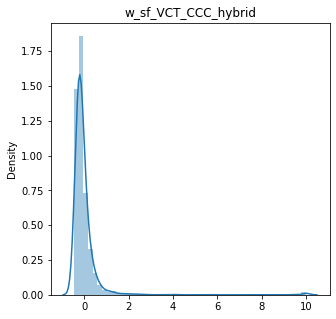

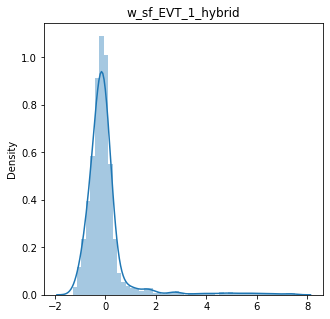

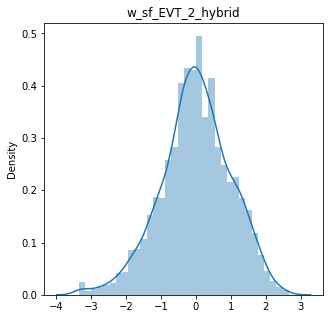

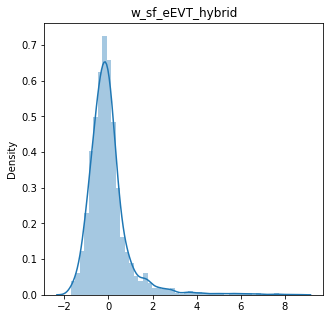

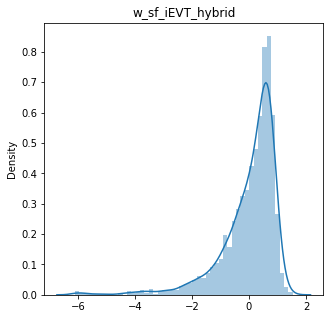

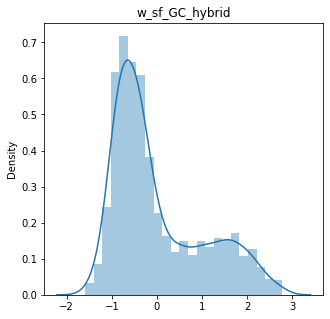

In [44]:
import matplotlib.pyplot as plt

# does the shape look somewhat Gaussian?

for i in range(adatas_ct_dens_gaussian['34914_WS_PLA_S9101765'].shape[1]):
    plt.figure(figsize=(5,5))
    plt.title(ct_data_cols[i])
    sns.distplot(adatas_ct_dens_gaussian['34914_WS_PLA_S9101765'].X[:,i])

In [45]:
IDs_to_run = IDs
IDs_to_run

['34914_WS_PLA_S9101764',
 '34914_WS_PLA_S9101765',
 '34914_WS_PLA_S9101766',
 '34914_WS_PLA_S9101767',
 '34882_WS_PLA_S9101769',
 '34882_WS_PLA_S9101770',
 '36173_Pla_HDBR9518710',
 '36173_Pla_Camb9518737']

In [46]:
ct_data_cols

['w_sf_VCT_CCC_hybrid',
 'w_sf_EVT_1_hybrid',
 'w_sf_EVT_2_hybrid',
 'w_sf_eEVT_hybrid',
 'w_sf_iEVT_hybrid',
 'w_sf_GC_hybrid']

____________

### In the foloowing few cells I figure out the neighboring spot-spot distance in Visium coordinates to then use it as the initial value for training of the length scale parameter `l` in the model

#### `l` is then converging during training to a value that is appropriate for each cell type pair

This is already done so please continue from after the line

In [47]:
# check coordinates to understand better what values to pass into model

In [48]:
import matplotlib.pyplot as plt

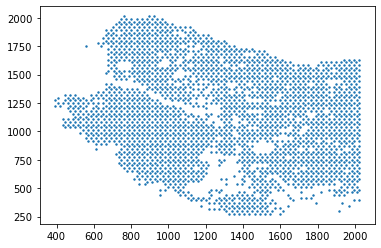

In [49]:
plt.scatter(adatas_ct_dens['34882_WS_PLA_S9101769'].obsm['spatial'][:,0], 
            adatas_ct_dens['34882_WS_PLA_S9101769'].obsm['spatial'][:,1], s=2)

In [50]:
adatas_ct_dens['34882_WS_PLA_S9101769'].obsm['spatial']

array([[1679, 1466],
       [ 405, 1297],
       [1858, 1347],
       ...,
       [ 856, 1656],
       [ 692, 1703],
       [ 651, 1345]])

In [51]:
adatas_ct_dens['34882_WS_PLA_S9101769']

AnnData object with n_obs × n_vars = 2583 × 6
    obsm: 'spatial'

### the spot-spot distance is about 29 in these units


In [52]:
np.unique(adatas_ct_dens['34882_WS_PLA_S9101769'].obsm['spatial'][:,0], return_counts = True)

(array([ 391,  405,  418,  432,  446,  459,  460,  473,  487,  500,  501,
         514,  515,  528,  542,  555,  556,  569,  570,  583,  596,  597,
         610,  611,  623,  624,  637,  638,  651,  652,  664,  665,  666,
         678,  679,  692,  693,  705,  706,  707,  719,  720,  721,  733,
         734,  746,  747,  748,  760,  761,  762,  774,  775,  776,  787,
         788,  789,  801,  802,  803,  815,  816,  817,  829,  830,  842,
         843,  844,  856,  857,  858,  870,  871,  872,  883,  884,  885,
         897,  898,  899,  911,  912,  913,  924,  925,  926,  938,  939,
         940,  952,  953,  954,  966,  967,  968,  979,  980,  981,  993,
         994,  995, 1007, 1008, 1009, 1021, 1022, 1023, 1034, 1035, 1036,
        1048, 1049, 1050, 1062, 1063, 1064, 1075, 1076, 1077, 1089, 1090,
        1091, 1103, 1104, 1105, 1117, 1118, 1119, 1130, 1131, 1132, 1144,
        1145, 1146, 1158, 1159, 1160, 1171, 1172, 1173, 1174, 1185, 1186,
        1187, 1199, 1200, 1201, 1213, 

In [53]:
np.unique(adatas_ct_dens['34882_WS_PLA_S9101769'].obsm['spatial'][:,1], return_counts = True)

(array([ 273,  297,  320,  321,  344,  345,  368,  369,  392,  393,  416,
         417,  439,  440,  441,  463,  464,  465,  487,  488,  511,  512,
         535,  536,  558,  559,  560,  582,  583,  584,  606,  607,  608,
         630,  631,  632,  654,  655,  678,  679,  701,  702,  703,  725,
         726,  727,  749,  750,  751,  773,  774,  775,  797,  798,  799,
         821,  822,  844,  845,  846,  868,  869,  870,  892,  893,  894,
         916,  917,  918,  940,  941,  942,  964,  965,  966,  987,  988,
         989, 1011, 1012, 1013, 1035, 1036, 1037, 1059, 1060, 1061, 1083,
        1084, 1085, 1106, 1107, 1108, 1109, 1130, 1131, 1132, 1154, 1155,
        1156, 1178, 1179, 1180, 1202, 1203, 1204, 1226, 1227, 1228, 1250,
        1251, 1252, 1273, 1274, 1275, 1276, 1297, 1298, 1299, 1321, 1322,
        1323, 1345, 1346, 1347, 1369, 1370, 1371, 1393, 1394, 1395, 1417,
        1418, 1419, 1441, 1442, 1443, 1465, 1466, 1489, 1490, 1512, 1513,
        1514, 1536, 1537, 1538, 1560, 

__________

In [1]:
# continue from here

In [54]:
# launch a bunch of models for l = [d; 2d; 3d; ...; 20d; 25d; 30d; 35d; 40d; 45d; 50d; 55d; 60d; 80d; 100d] 
# where d = 29 is the distance between 2 neighboring spots in Visium coordinates
# --> 30 values

# TO DO: run models with a bunch of initail values of `l` parameter

Change:
```python
self.kernel.lengthscales = gpflow.Parameter(value=self.kernel.lengthscales, transform = gpflow.utilities.positive(lower=1e-1))
```
to:
```python
self.kernel.lengthscales = gpflow.Parameter(value=num_value, transform = gpflow.utilities.positive(lower=1e-1))
```
where `num_value` is a concrete numerical value that will be used to initialise the model, then it should converge to a better fitting value

Try a few of `num_values`, for example, from d to 100*d where d is the distance b/w neighbouring spots


In [55]:
class FullRandomEffectsModel_l(tf.Module):
    def __init__(self, 
                 Y1, # ct1 density vector
                 Y2, # ct2 density vector
                 X, # spot coordinates
                 #labels # don't need - tissue region labels
                 l_value, # numerical value of l parameter to start with (then will converge)
                ):
        self.Y1 = np.squeeze(Y1)
        self.Y2 = np.squeeze(Y2)
        
        self.Y1 = (self.Y1 - np.mean(self.Y1)) / np.std(self.Y1)
        self.Y2 = (self.Y2 - np.mean(self.Y2)) / np.std(self.Y2)
        
        self.Y = tf.concat((self.Y1, self.Y2), axis=0)
        self.coords = tf.cast(X, dtype=tf.float64)
        #self.labels = labels
        self.e = tf.Variable(tf.ones(shape=(2,2), dtype=tf.float64))
        self.sigma = gpflow.Parameter([1,1], dtype=tf.float64, transform=gpflow.utilities.positive(lower=1e-6))
        
        # label stuff - don't need
        #X = np.zeros((norm.n_obs, np.max(self.labels) + 1))
        #X[np.arange(norm.n_obs), self.labels] = 1
        #self.X = tf.cast(X, dtype=tf.float64)
        #self.XXt = tf.matmul(self.X, self.X, transpose_b=True)
        
        self.kernel = gpflow.kernels.SquaredExponential()
        gpflow.utilities.set_trainable(self.kernel.variance, False)
        #self.kernel.lengthscales.transform = gpflow.utilities.positive(lower=1e-1)
        self.kernel.lengthscales = gpflow.Parameter(value=l_value, transform = gpflow.utilities.positive(lower=1e-1))
        
        self.e_null = gpflow.Parameter([1,1], dtype=tf.float64, transform=gpflow.utilities.positive(lower=1e-6))
        self.sigma_null = gpflow.Parameter([1,1], dtype=tf.float64, transform=gpflow.utilities.positive(lower=1e-6))
        self.kernel_null = gpflow.kernels.SquaredExponential()
        gpflow.utilities.set_trainable(self.kernel_null.variance, False)
        #self.kernel_null.lengthscales.transform=gpflow.utilities.positive(lower=1e-1)
        self.kernel_null.lengthscales = gpflow.Parameter(value=l_value, transform = gpflow.utilities.positive(lower=1e-1))
        
        
    def covmat(self, null=False):
        #smalleye = tf.linalg.LinearOperatorIdentity(2, dtype=tf.float64)
        bigeye = tf.linalg.LinearOperatorIdentity(self.Y1.shape[0], dtype=tf.float64)
        
        #regionvar = tf.linalg.LinearOperatorKronecker((smalleye, tf.linalg.LinearOperatorFullMatrix(self.XXt)))
        
        if not null:
            spatialvar = tf.linalg.LinearOperatorLowerTriangular(self.e)
            spatialvar = spatialvar @ spatialvar.adjoint()
            kern = self.kernel
            
            noisevar = tf.linalg.LinearOperatorDiag(self.sigma)
        else:
            spatialvar = tf.linalg.LinearOperatorDiag(self.e_null)
            kern = self.kernel_null
            noisevar = tf.linalg.LinearOperatorDiag(self.sigma_null)
        
        #spatialvar = tf.linalg.LinearOperatorKronecker((spatialvar, tf.linalg.LinearOperatorFullMatrix(self.XXt * kern(self.coords))))
        spatialvar = tf.linalg.LinearOperatorKronecker((spatialvar, tf.linalg.LinearOperatorFullMatrix(kern(self.coords))))
        noisevar = tf.linalg.LinearOperatorKronecker((noisevar, bigeye))
        #return regionvar.to_dense() + spatialvar.to_dense() + noisevar.to_dense()
        return spatialvar.to_dense() + noisevar.to_dense()
    
    def loglik(self, null=False):
        var = self.covmat(null)
        chol = tf.linalg.cholesky(var)
        ldet = tf.reduce_sum(2 * tf.math.log(tf.linalg.diag_part(chol)))

        residual = self.Y
        
        # old incorrect version of this expression
        #quad = tf.tensordot(residual, tf.squeeze(tf.linalg.cholesky_solve(chol, residual[:, tf.newaxis])), axes=(-1, -1))
        
        # new corrected version of this expression
        quad = tf.reduce_sum(tf.square(tf.linalg.cholesky_solve(chol, residual[:, tf.newaxis])))
        
        return -0.5 * ldet - 0.5 * quad
    
    def lrt(self):
        return -2 * (self.loglik(null=True) - self.loglik())

In [57]:
# launch a bunch of models for l = [d; 2d; 3d; ...; 20d; 25d; 30d; 35d; 40d; 45d; 50d; 55d; 60d; 80d; 100d] 
# --> 30 values
# d = 29

In [58]:
# neighbouring spot-spot distance is 29 in these units
l_values = [29*i for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
                           #16,17,18,19,20,25,30,35,40,45,50,55,60,80,100,
                          ]]

In [59]:
l_values

[29, 58, 87, 116, 145, 174, 203, 232, 261, 290, 319, 348, 377, 406, 435]

In [60]:
# to do - just with 29 will do for now, this worked best
l_values = l_values[0:1]

In [61]:
l_values

[29]

In [62]:
IDs

['34914_WS_PLA_S9101764',
 '34914_WS_PLA_S9101765',
 '34914_WS_PLA_S9101766',
 '34914_WS_PLA_S9101767',
 '34882_WS_PLA_S9101769',
 '34882_WS_PLA_S9101770',
 '36173_Pla_HDBR9518710',
 '36173_Pla_Camb9518737']

In [63]:
l_values

[29]

In [65]:
ct_data_cols

['w_sf_VCT_CCC_hybrid',
 'w_sf_EVT_1_hybrid',
 'w_sf_EVT_2_hybrid',
 'w_sf_eEVT_hybrid',
 'w_sf_iEVT_hybrid',
 'w_sf_GC_hybrid']

In [66]:
for i, ct1 in enumerate(list(ct_data_cols)):
    for j, ct2 in enumerate(list(ct_data_cols[i + 1:])):
        print(ct1,ct2)

w_sf_VCT_CCC_hybrid w_sf_EVT_1_hybrid
w_sf_VCT_CCC_hybrid w_sf_EVT_2_hybrid
w_sf_VCT_CCC_hybrid w_sf_eEVT_hybrid
w_sf_VCT_CCC_hybrid w_sf_iEVT_hybrid
w_sf_VCT_CCC_hybrid w_sf_GC_hybrid
w_sf_EVT_1_hybrid w_sf_EVT_2_hybrid
w_sf_EVT_1_hybrid w_sf_eEVT_hybrid
w_sf_EVT_1_hybrid w_sf_iEVT_hybrid
w_sf_EVT_1_hybrid w_sf_GC_hybrid
w_sf_EVT_2_hybrid w_sf_eEVT_hybrid
w_sf_EVT_2_hybrid w_sf_iEVT_hybrid
w_sf_EVT_2_hybrid w_sf_GC_hybrid
w_sf_eEVT_hybrid w_sf_iEVT_hybrid
w_sf_eEVT_hybrid w_sf_GC_hybrid
w_sf_iEVT_hybrid w_sf_GC_hybrid


In [2]:
# the important output to then be used later in joint trajectory inference is values of spatial covariance
# for each cell type pair combination

In [67]:
%%time
# takes about 15 minutes per model run (on all 4 chips)
# started at ~08:07, 22.02.2022
# takes about 40 minutes on all relevant chips (8)
results = {}
dfs = {}

dfs_lengthscales = {}

opt = gpflow.optimizers.Scipy()

for ID in IDs_to_run:
    print(ID)
    results[ID] = {}
    dfs[ID] = {}
    dfs_lengthscales[ID] = {}

    
    for curr_l_value in l_values:
        print('curr_l_value', curr_l_value)
        results[ID]['l_value_' + str(curr_l_value)] = {}
        dfs_lengthscales[ID]['l_value_' + str(curr_l_value)] = pd.DataFrame(columns = ['ct1','ct2','kernel_lengthscales'])

    
        for i, ct1 in enumerate(list(ct_data_cols)):
            for j, ct2 in enumerate(list(ct_data_cols[i + 1:])):
                print(ct1,ct2)
                lmm = FullRandomEffectsModel_l(adatas_ct_dens_gaussian[ID][:, ct1].X, 
                                               adatas_ct_dens_gaussian[ID][:, ct2].X, 
                                               adatas_ct_dens_gaussian[ID].obsm["spatial"], 
                                             #segmentation.labels
                                             l_value = curr_l_value
                                            )
                res = opt.minimize(lambda: -lmm.loglik() - lmm.loglik(null=True), variables=lmm.trainable_variables, method='bfgs')
                results[ID]['l_value_' + str(curr_l_value)][(ct1, ct2)] = lmm
                print(res.nit)
        
        dfs[ID]['l_value_' + str(curr_l_value)] = pd.DataFrame([{'ct1': k[0], 'ct2': k[1], 
                        'cor':v.e[0,0].numpy() * v.e[1,0].numpy() / (np.sqrt(v.e[0,0].numpy() ** 2 + v.sigma[0]**2) * np.sqrt(v.e[1,0].numpy()**2 + v.e[1,1].numpy() ** 2 + v.sigma[1].numpy()**2))} for k,v in results[ID]['l_value_' + str(curr_l_value)].items()])
        dfs[ID]['l_value_' + str(curr_l_value)].to_csv('/nfs/team292/aa22/SpatialDE_colocation_model_related/results/20220222_SpatialDE_pairwise_corr_model_region_spot_selection_chip_' + ID + '_kernel_lenghtscales_' + str(curr_l_value) + '.csv')

        
        # get and save the l parameter tables
        idx_count = 0
        
        for k,v in results[ID]['l_value_' + str(curr_l_value)].items():
            print(k,v.kernel.lengthscales)
            dfs_lengthscales[ID]['l_value_' + str(curr_l_value)].loc[idx_count,'ct1'] = k[0] 
            dfs_lengthscales[ID]['l_value_' + str(curr_l_value)].loc[idx_count,'ct2'] = k[1] 
            dfs_lengthscales[ID]['l_value_' + str(curr_l_value)].loc[idx_count,'kernel_lengthscales'] = v.kernel.lengthscales.numpy()

            idx_count += 1

        # save these lengthscale parameter tables
        dfs_lengthscales[ID]['l_value_' + str(curr_l_value)].to_csv('/nfs/team292/aa22/SpatialDE_colocation_model_related/results/20220222_SpatialDE_pairwise_corr_model_region_spot_selection_chip_' + ID + '_kernel_lengthscale_table_' + str(curr_l_value) + '.csv')
        

34914_WS_PLA_S9101764
curr_l_value 29
w_sf_VCT_CCC_hybrid w_sf_EVT_1_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f7896b80>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f7896b80>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Do not call `graph_parents`.
31
w_sf_VCT_CCC_hybrid w_sf_EVT_2_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f79cc550>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f79cc550>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
33
w_sf_VCT_CCC_hybrid w_sf_eEVT_hybrid

Cause: could not parse the source code of <function <lambda> at 0x7fd1f7bafb80>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32
w_sf_eEVT_hybrid w_sf_GC_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f1017ca0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f1017ca0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
30
w_sf_iEVT_hybrid w_sf_GC_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f12c99d0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f12c99d0>: no matching AST found
To silence this warning, decorate the f

Cause: could not parse the source code of <function <lambda> at 0x7fd1f6c46280>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
26
w_sf_EVT_1_hybrid w_sf_GC_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0c783a0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0c783a0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29
w_sf_EVT_2_hybrid w_sf_eEVT_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0b48430>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0b48430>: no matching AST found
To silence this warning, decorate t

Cause: could not parse the source code of <function <lambda> at 0x7fd1f791d4c0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
27
w_sf_VCT_CCC_hybrid w_sf_iEVT_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f6ebc430>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f6ebc430>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
33
w_sf_VCT_CCC_hybrid w_sf_GC_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f6b3d1f0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f6b3d1f0>: no matching AST found
To silence this warning, decora

Cause: could not parse the source code of <function <lambda> at 0x7fd1f7dbf4c0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f7dbf4c0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23
w_sf_VCT_CCC_hybrid w_sf_EVT_2_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f1318700>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f1318700>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
31
w_sf_VCT_CCC_hybrid w_sf_eEVT_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f14c0e50>: no matching AST found
To silence this warning, dec

27
w_sf_eEVT_hybrid w_sf_GC_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0442790>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0442790>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32
w_sf_iEVT_hybrid w_sf_GC_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f7931dc0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f7931dc0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41
('w_sf_VCT_CCC_hybrid', 'w_sf_EVT_1_hybrid') <Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=33.14221412377726>

Cause: could not parse the source code of <function <lambda> at 0x7fd1f10edf70>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29
w_sf_EVT_1_hybrid w_sf_GC_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f10eaee0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f10eaee0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32
w_sf_EVT_2_hybrid w_sf_eEVT_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0a3ab80>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0a3ab80>: no matching AST found
To silence this warning, decorate t

Cause: could not parse the source code of <function <lambda> at 0x7fd1f0d119d0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
27
w_sf_VCT_CCC_hybrid w_sf_iEVT_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0492820>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0492820>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32
w_sf_VCT_CCC_hybrid w_sf_GC_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f11e9c10>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f11e9c10>: no matching AST found
To silence this warning, decora

Cause: could not parse the source code of <function <lambda> at 0x7fd1f6f22c10>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f6f22c10>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
52
w_sf_VCT_CCC_hybrid w_sf_EVT_2_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f00c7f70>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f00c7f70>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
38
w_sf_VCT_CCC_hybrid w_sf_eEVT_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f008d430>: no matching AST found
To silence this warning, dec

36
w_sf_eEVT_hybrid w_sf_GC_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f10eda60>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f10eda60>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
34
w_sf_iEVT_hybrid w_sf_GC_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f05e1310>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f05e1310>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
45
('w_sf_VCT_CCC_hybrid', 'w_sf_EVT_1_hybrid') <Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=16.631600413678967

Cause: could not parse the source code of <function <lambda> at 0x7fd1f0fdadc0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
35
w_sf_EVT_1_hybrid w_sf_GC_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0907af0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0907af0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
36
w_sf_EVT_2_hybrid w_sf_eEVT_hybrid
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0092550>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fd1f0092550>: no matching AST found
To silence this warning, decorate t